# Set up workspace

In [56]:
print("Hello World")

Hello World


## Import packages etc

In [109]:
import pandas as pd
import numpy as np
import re
import datetime
from azureml.core import Workspace, Dataset, workspace

subscription_id = 'f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17'
resource_group = 'hackathon'
workspace_name = 'Iteration1_ML'

workspace = Workspace(subscription_id, resource_group, workspace_name)

# Set up experiment

In [110]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

In [111]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'non_COVID_model_JP'

# # project folder
# project_folder = './sample_projects/automl-forecasting-energy-demand'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17
Workspace,iteration1_ml
Resource Group,hackathon
Location,eastus2
Run History Name,non_COVID_model_JP


# Create AmlCompute

In [112]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = "flights-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Set up designated variables

In [113]:
target_column_name = 'counts_x'
time_column_name = 'Date'

## Read in data as dataset tabular object

In [114]:
dataset = Dataset.get_by_name(workspace, name='ATL_training_autoML').with_timestamp_columns(fine_grain_timestamp=time_column_name) 
#preview first 5 rows
dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,19556,ATL,2019-01-01,GA,952,Tuesday,1,1,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,19562,ATL,2019-01-02,GA,1241,Wednesday,2,2,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,19568,ATL,2019-01-03,GA,1162,Thursday,3,3,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,19574,ATL,2019-01-04,GA,1164,Friday,4,4,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,19580,ATL,2019-01-05,GA,865,Saturday,5,5,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Split the data into train and test sets

In [115]:
# split into train based on time, non covid times
train0 = dataset.time_before(datetime(2020, 3, 1, 0), include_boundary=False)
train0.to_pandas_dataframe().reset_index(drop=True).sort_values(time_column_name).head(5)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,19556,ATL,2019-01-01,GA,952,Tuesday,1,1,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,19562,ATL,2019-01-02,GA,1241,Wednesday,2,2,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,19568,ATL,2019-01-03,GA,1162,Thursday,3,3,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,19574,ATL,2019-01-04,GA,1164,Friday,4,4,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,19580,ATL,2019-01-05,GA,865,Saturday,5,5,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [116]:
# split into covid period based on time
test0 = dataset.time_between(datetime(2020, 3, 1, 0), datetime(2020, 12, 31, 0))
test0.to_pandas_dataframe().reset_index(drop=True).head(5)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,19916,ATL,2020-03-01,GA,1202,Sunday,6,1,March,3,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,19922,ATL,2020-03-02,GA,1310,Monday,0,2,March,3,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,19928,ATL,2020-03-03,GA,1282,Tuesday,1,3,March,3,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,19934,ATL,2020-03-04,GA,1286,Wednesday,2,4,March,3,...,2.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,19940,ATL,2020-03-05,GA,1295,Thursday,3,5,March,3,...,2.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### There are too many input columns.  Do first round of feature selection

In [117]:
varsToKeep=[
'Date',
'counts_x',
'DOW_x',
'day_x',
'month_x',
'mint',
'maxt',
'temp',
'dew',
'humidity',
'wspd',
'precip',
'precipcover',
'snowdepth',
'visibility',
'cloudcover',
'sealevelpressure',
'weathertype',
'conditions']

# =============================================================================
# removed these for being covid related (in non-covid model)
#'positiveIncrease',
#'deathIncrease',
#'hospitalizedIncrease'

# removed these for being cumulative
#'positive',
#'probableCases',
#'death',

# removed these for being all 0
#'hospitalizedCurrently',
#'inIcuCurrently',
#'onVentilatorCurrently',


#removed these for being missing
#'wgust',
#'windchill',
#'heatindex',
# =============================================================================

In [118]:
train=train0.keep_columns(varsToKeep)
test=test0.keep_columns(varsToKeep)

In [119]:
#print for viewing
train.to_pandas_dataframe().reset_index(drop=True).head(5)

,Date,counts_x,DOW_x,day_x,month_x,mint,maxt,temp,dew,humidity,wspd,precip,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions
0,2019-01-01,952,Tuesday,1,January,57.80,65.90,62.80,58.30,85.35,6.90,0.14,29.17,0.00,8.30,71.70,1019.10,"Mist, Rain, Fog, Heavy Rain, Light Rain","Rain, Partially cloudy"
1,2019-01-02,1241,Wednesday,2,January,48.80,59.00,53.70,49.40,85.47,9.10,0.45,41.67,0.00,7.30,77.00,1020.90,"Mist, Rain, Fog, Heavy Rain, Light Rain","Rain, Overcast"
2,2019-01-03,1162,Thursday,3,January,50.00,55.10,53.10,50.60,91.37,13.80,0.23,50.00,0.00,2.80,88.50,1016.70,"Mist, Light Drizzle, Rain, Heavy Rain, Light Rain","Rain, Overcast"
3,2019-01-04,1164,Friday,4,January,45.00,65.90,55.10,49.20,81.49,25.20,1.45,50.00,0.00,5.30,79.60,1008.90,"Mist, Light Drizzle, Rain, Fog, Heavy Rain, Light Rain","Rain, Overcast"
4,2019-01-05,865,Saturday,5,January,44.00,59.00,49.40,36.30,61.79,20.70,0.00,0.00,0.00,9.90,36.40,1015.80,None,Partially cloudy


In [120]:
#print for viewing
test.to_pandas_dataframe().reset_index(drop=True).head(5)

,Date,counts_x,DOW_x,day_x,month_x,mint,maxt,temp,dew,humidity,wspd,precip,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions
0,2020-03-01,1202,Sunday,1,March,35.00,64.10,50.00,27.90,44.53,10.30,0.00,0.00,0.00,9.90,56.30,1024.10,None,Partially cloudy
1,2020-03-02,1310,Monday,2,March,47.00,55.10,52.20,43.20,73.34,11.40,0.94,54.17,0.00,6.50,75.10,1017.60,"Mist, Rain, Heavy Rain, Light Rain","Rain, Overcast"
2,2020-03-03,1282,Tuesday,3,March,56.00,69.20,63.50,59.30,86.42,18.30,0.46,25.00,0.00,7.50,78.50,1011.00,"Lightning Without Thunder, Mist, Thunderstorm, Rain, Fog, Heavy Rain, Light Rain","Rain, Overcast"
3,2020-03-04,1286,Wednesday,4,March,53.90,62.00,56.70,52.00,84.60,11.30,0.91,100.00,0.00,6.70,78.90,1015.40,"Mist, Rain, Heavy Rain, Light Rain","Rain, Overcast"
4,2020-03-05,1295,Thursday,5,March,50.00,53.00,51.30,47.10,85.76,18.30,1.64,70.83,0.00,5.70,90.30,1016.50,"Lightning Without Thunder, Mist, Light Drizzle, Rain, Heavy Rain, Light Rain","Rain, Overcast"


### Set forecast horizon

In [121]:
forecast_horizon = 30

# Train the model!

In [123]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    freq='D'
)

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             blocked_models = ['ExtremeRandomTrees', 'Prophet','VotingEnsemble'],                             
                             experiment_timeout_hours=0.3,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,                             
                             verbosity=logging.INFO,
                             forecasting_parameters=forecasting_parameters,
                             enable_voting_ensemble=False)

In [124]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run.wait_for_completion()

Running on remote.
No run_configuration provided, running on flights-cluster with default configuration
Running on remote compute: flights-cluster
Parent Run ID: AutoML_b6d79ad7-fb0d-4d19-b896-75582d3edfec



##Retrieve the Best Model

In [73]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps
#fitted_model

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None,
                        lookback_features_removed=False,
                        pipeline=<azureml.automl.runtime.featurizer.transformer.timeseries.forecasting_pipeline.AzureMLForecastPipeline object at 0x7f4367f78a58>,
                        pipeline_type=<TimeSeriesPipelineType.FULL: 1>,
                        time_index_non_holiday_features=['_automl_year',
                                                         '_automl_year_iso',
                                                         '_automl_half',
                                                         '_automl_quarter',
                                                         '_automl_month',
                                                         '_automl_day',
                                                         '_automl_wday',
                                                         '_automl_qday',
                                                         '_automl_week'])),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('4',
                                            Pipeline(memory=None,
                                                     steps=[('robustscaler',
                                                             RobustScaler(copy=True,
                                                                          quantile_range=[10,
                                                                                          90],
                                                                          with_centering=False,
                                                                          with_scaling=True)),
                                                            ('decisiontreeregressor',
                                                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                   criterion='friedman_mse',
                                                                                   max_depth=None,
                                                                                   max_features=None,
                                                                                   max_leaf_nodes=None,
                                                                                   min_impurity_decrease=0.0,
                                                                                   min_impu...
                                                                        normalize=False,
                                                                        positive=False,
                                                                        precompute=False,
                                                                        random_state=None,
                                                                        selection='cyclic',
                                                                        tol=0.0001,
                                                                        warm_start=False))],
                                                     verbose=False)),
                                           ('0',
                                            Pipeline(memory=None,
                                                     steps=[('autoarima',
                                                             <azureml.automl.runtime.shared._auto_arima.AutoArima object at 0x7f436ad772e8>)],
                                                     verbose=False))],
                               weights=[0.5333333333333333, 0.3333333333333333,
                                        0.06666666666666667,
                                        0.06666666666666667]))]

##View featurization

In [74]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['Departure_Airport',
 'Departure_state_x',
 'DOW_x',
 'day_x',
 'month_x',
 'mint',
 'maxt',
 'temp',
 'dew',
 'humidity',
 'wspd',
 'precip',
 'precipcover',
 'snowdepth',
 'visibility',
 'cloudcover',
 'sealevelpressure',
 'weathertype',
 'conditions',
 'positiveIncrease',
 'deathIncrease',
 'hospitalizedIncrease',
 '_automl_target_col_WASNULL',
 'day_x_WASNULL',
 'mint_WASNULL',
 'maxt_WASNULL',
 'temp_WASNULL',
 'dew_WASNULL',
 'humidity_WASNULL',
 'wspd_WASNULL',
 'precip_WASNULL',
 'precipcover_WASNULL',
 'snowdepth_WASNULL',
 'visibility_WASNULL',
 'cloudcover_WASNULL',
 'sealevelpressure_WASNULL',
 'positiveIncrease_WASNULL',
 'deathIncrease_WASNULL',
 'hospitalizedIncrease_WASNULL',
 '_automl_year',
 '_automl_year_iso',
 '_automl_half',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_hour',
 '_automl_am_pm',
 '_automl_hour12',
 '_automl_wday',
 '_automl_qday',
 '_automl_week']

In [75]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Departure_Airport,Categorical,No,1,[LabelEncoder]
1,Departure_state_x,Categorical,No,1,[LabelEncoder]
2,DOW_x,Categorical,No,1,[LabelEncoder]
3,day_x,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,month_x,Categorical,No,1,[LabelEncoder]
5,mint,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,maxt,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,dew,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,humidity,Numeric,No,2,"[MedianImputer, ImputationMarker]"


#Forecast against the test sample

In [76]:
X_test = test.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(target_column_name).values

In [77]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

##Evaluate

In [78]:
import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset


def align_outputs(y_predicted, X_trans, X_test, y_test, target_column_name,
                  predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """

    if (horizon_colname in X_trans):
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted,
                                horizon_colname: X_trans[horizon_colname]})
    else:
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted})

    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index

    # align original X_test to y_test
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')

    # drop rows where prediction or actuals are nan
    # happens because of missing actuals
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name,
                               predicted_column_name]].notnull().all(axis=1)]
    return(clean)

In [79]:
df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 26 columns):
Date                       306 non-null datetime64[ns]
_automl_dummy_grain_col    306 non-null object
predicted                  306 non-null float64
Departure_Airport          306 non-null object
Departure_state_x          306 non-null object
DOW_x                      306 non-null object
day_x                      306 non-null int64
month_x                    306 non-null object
mint                       306 non-null float64
maxt                       306 non-null float64
temp                       306 non-null float64
dew                        306 non-null float64
humidity                   306 non-null float64
wspd                       306 non-null float64
precip                     306 non-null float64
precipcover                306 non-null float64
snowdepth                  306 non-null float64
visibility                 306 non-null float64
cloudcover                 306 

[Test data scores]

normalized_mean_absolute_error:   0.440
spearman_correlation:   -0.113
normalized_root_mean_squared_log_error:   0.451
normalized_median_absolute_error:   0.418
mean_absolute_error:   470.862
normalized_root_mean_squared_error:   0.518
mean_absolute_percentage_error:   92.054
median_absolute_error:   447.123
root_mean_squared_log_error:   0.699
root_mean_squared_error:   553.213
explained_variance:   -0.169
r2_score:   -1.000


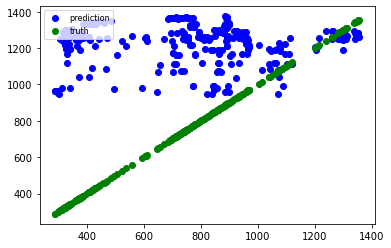

In [80]:

from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl metrics module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

#Explore the results, another way

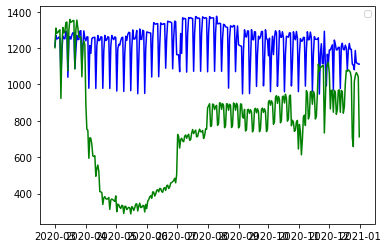

In [81]:
#plot the actual vs predicted as a time series plot
%matplotlib inline
test_pred = plt.plot(df_all['Date'], df_all['predicted'], color='b')
test_test = plt.plot(df_all['Date'], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='best', fontsize=8)
plt.show()


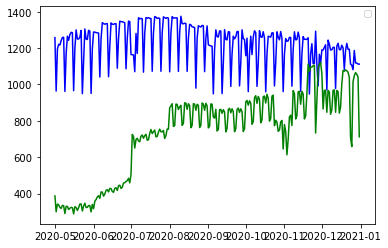

In [82]:
#zoom in
import datetime
%matplotlib inline
new_df_all=df_all[(df_all.Date>=datetime.datetime(2020, 5, 1, 0, 0, 0))]
new_df_all.Date

test_pred = plt.plot(new_df_all['Date'], new_df_all['predicted'], color='b')
test_test = plt.plot(new_df_all['Date'], new_df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='best', fontsize=8)
plt.show()

In [83]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [ ]:
#https://docs.microsoft.com/en-us/azure/machine-learning/how-to-machine-learning-interpretability-automl

from azureml.interpret import ExplanationClient

client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())

In [86]:
from azureml.interpret import ExplanationClient

client = ExplanationClient.from_run(best_run)
raw_explanations = client.download_model_explanation(raw=True)
print(raw_explanations.get_feature_importance_dict())

{'Date': 141.1699058665912, 'month_x': 0.48513023151753215, 'Departure_Airport': 0.46140984334730284, 'temp': 0.3463091422091035, 'dew': 0.288415809409794, 'mint': 0.2861640036223294, 'conditions': 0.2579321722907624, 'weathertype': 0.1957221285481999, 'DOW_x': 0.14246979688763026, 'cloudcover': 0.12388783300102002, 'day_x': 0.11434070589344883, 'precip': 0.11022951643454491, 'humidity': 0.10264643422680135, 'maxt': 0.09899844584543928, 'sealevelpressure': 0.09187943002858939, 'visibility': 0.08017691239153085, 'wspd': 0.06276455289953489, 'precipcover': 0.059024575073223375, 'deathIncrease': 0.0, 'snowdepth': 0.0, 'Departure_state_x': 0.0, 'positiveIncrease': 0.0, 'hospitalizedIncrease': 0.0}


In [93]:
automl_run, fitted_model = remote_run.get_output()

In [108]:
from azureml.train.automl.runtime.automl_explain_utilities import automl_setup_model_explanations

X_train = train.to_pandas_dataframe().reset_index(drop=True)
y_train = test0.keep_columns('Date','counts_x').to_pandas_dataframe().reset_index(drop=True)

y_train
#automl_explainer_setup_obj = automl_setup_model_explanations(fitted_model, X=X_train, 
#                                                             X_test=X_test, y=y_train, 
#                                                             task='forecasting')


,Date
0,2020-03-01
1,2020-03-02
2,2020-03-03
3,2020-03-04
4,2020-03-05
...,...
301,2020-12-27
302,2020-12-28
303,2020-12-29
304,2020-12-30


In [96]:
from azureml.interpret import MimicWrapper

# Initialize the Mimic Explainer
explainer = MimicWrapper(ws, automl_explainer_setup_obj.automl_estimator,
                         explainable_model=automl_explainer_setup_obj.surrogate_model, 
                         init_dataset=automl_explainer_setup_obj.X_transform, run=automl_run,
                         features=automl_explainer_setup_obj.engineered_feature_names, 
                         feature_maps=[automl_explainer_setup_obj.feature_map],
                         classes=automl_explainer_setup_obj.classes,
                         explainer_kwargs=automl_explainer_setup_obj.surrogate_model_params)

ForecastingDataException: ForecastingDataException:
	Message: One or more columns for [time_column_name:Date] were not found in the dataframe.
Please check that these columns are present in your dataframe. You can run `<X>.columns`.
	InnerException: None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "One or more columns for [time_column_name:Date] were not found in the dataframe.\nPlease check that these columns are present in your dataframe. You can run `<X>.columns`.",
        "target": "Time",
        "inner_error": {
            "code": "BadData",
            "inner_error": {
                "code": "MissingData"
            }
        },
        "reference_code": "aa38835e-9b7c-11ea-860b-04d3b0c6010a"
    }
}